In [ ]:
import zipfile
from google.colab import drive
drive.mount('/content/drive/')
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/aider_data.zip",
'r')
zip_ref.extractall("/tmp")
zip_ref.close()

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Models
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D

import os

folder_path = '/tmp/AIDER'
for dirname, _, filenames in os.walk(folder_path):
    print(dirname)

/tmp/AIDER
/tmp/AIDER/flooded_areas
/tmp/AIDER/traffic_incident
/tmp/AIDER/collapsed_building
/tmp/AIDER/normal
/tmp/AIDER/fire


In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

In [ ]:
import matplotlib.image as mpimg
%matplotlib inline


train_datagen = ImageDataGenerator(
                fill_mode = 'nearest',
                validation_split=0.2
                )


train_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    )


validation_generator=train_datagen.flow_from_directory(
    folder_path,
    target_size=(108,108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    )

Found 5147 images belonging to 5 classes.
Found 1286 images belonging to 5 classes.


In [ ]:
from keras.applications import ResNet152
model = tf.keras.models.Sequential([
    ResNet152(input_shape=(108,108,3), include_top=False),
    ])
for layer in model.layers:
    layer.trainable = False


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
model.summary()

234698864/234698864 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 4, 4, 2048)        58370944  
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 64)          1179712   
                                                                 
 max_pooling2d (MaxPooling2  (None, 1, 1, 64)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                

In [ ]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1,
                    )

Epoch 1/25
161/161 [==============================] - 38s 147ms/step - loss: 0.9328 - accuracy: 0.7571 - val_loss: 0.4897 - val_accuracy: 0.8600
Epoch 2/25
161/161 [==============================] - 19s 120ms/step - loss: 0.4408 - accuracy: 0.8692 - val_loss: 0.4328 - val_accuracy: 0.8585
Epoch 3/25
161/161 [==============================] - 18s 112ms/step - loss: 0.2522 - accuracy: 0.9223 - val_loss: 0.3609 - val_accuracy: 0.8896
Epoch 4/25
161/161 [==============================] - 18s 112ms/step - loss: 0.1732 - accuracy: 0.9485 - val_loss: 0.5028 - val_accuracy: 0.8942
Epoch 5/25
161/161 [==============================] - 18s 112ms/step - loss: 0.1151 - accuracy: 0.9662 - val_loss: 0.5506 - val_accuracy: 0.8927
Epoch 6/25
161/161 [==============================] - 18s 113ms/step - loss: 0.0964 - accuracy: 0.9711 - val_loss: 0.5508 - val_accuracy: 0.8639
Epoch 7/25
161/161 [==============================] - 18s 113ms/step - loss: 0.0857 - accuracy: 0.9755 - val_loss: 0.5592 - val_ac

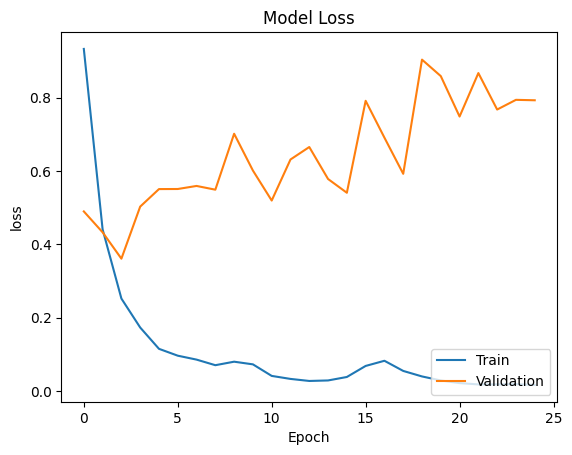

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

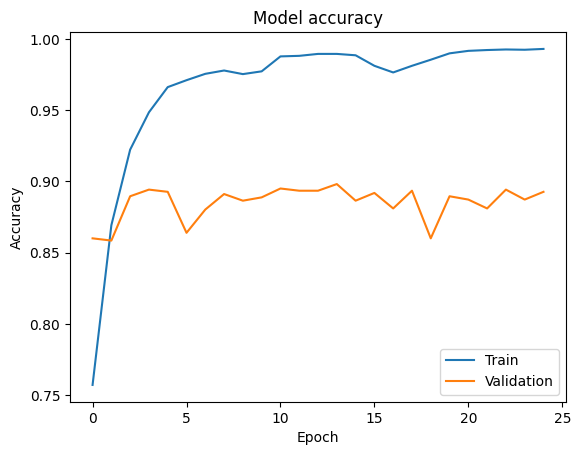

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
# Fine-tuning
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

# Data Augmentation
train_datagen = ImageDataGenerator(
    fill_mode='nearest',
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    )

validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    validation_split=0.2,
    )

# Note: No need for a separate test data generator
# Train, Validation, and Test Generators
train_generator = train_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    subset='training',
    )

validation_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    subset='validation',
    )


# Note: No need for a separate test generator
# Use the entire dataset for testing
test_generator = validation_datagen.flow_from_directory(
    folder_path,
    target_size=(108, 108),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False, # Do not shuffle the test set
    )


# Build Model
model = Sequential([
      ResNet152(input_shape=(108, 108, 3), include_top=False),
])

# Freeze ResNet layers
for layer in model.layers:
      layer.trainable = False


# Add Custom Classification Head
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(5, activation='softmax'))
# Compile Model
optimizer = Adam(learning_rate=0.001)


model.compile(optimizer=optimizer, loss='categorical_crossentropy',
metrics=['accuracy'])

# Train Model
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=25,
                    verbose=1,
                    )


# Evaluate on the Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy}")

# Predict classes for the test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
# Get true classes from the generator
y_true = test_generator.classes
# Convert one-hot encoded class labels to integer labels
class_labels = list(test_generator.class_indices.keys())
y_true_labels = [class_labels[i] for i in y_true]
y_pred_labels = [class_labels[i] for i in y_pred_classes]
# Print the classification report
print(classification_report(y_true_labels, y_pred_labels))

Found 5147 images belonging to 5 classes.
Found 1286 images belonging to 5 classes.
Found 6433 images belonging to 5 classes.
Epoch 1/25
161/161 [==============================] - 45s 222ms/step - loss: 1.1120 - accuracy: 0.7049 - val_loss: 0.6601 - val_accuracy: 0.7862
Epoch 2/25
161/161 [==============================] - 35s 218ms/step - loss: 0.7123 - accuracy: 0.7717 - val_loss: 0.6054 - val_accuracy: 0.8118
Epoch 3/25
161/161 [==============================] - 32s 201ms/step - loss: 0.6216 - accuracy: 0.7873 - val_loss: 0.5122 - val_accuracy: 0.8289
Epoch 4/25
161/161 [==============================] - 33s 204ms/step - loss: 0.6041 - accuracy: 0.7956 - val_loss: 0.5894 - val_accuracy: 0.8110
Epoch 5/25
161/161 [==============================] - 33s 204ms/step - loss: 0.5112 - accuracy: 0.8189 - val_loss: 0.5719 - val_accuracy: 0.8398
Epoch 6/25
161/161 [==============================] - 32s 200ms/step - loss: 0.4912 - accuracy: 0.8440 - val_loss: 0.4920 - val_accuracy: 0.8616
Epoc